In [1]:
import math
import os
import shutil
import time
import numpy as np
from datetime import datetime
import json

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.models as models
from HSI_class import HSI
import createSample as CS
import augmentation as aug

import simsiam.loader
import random
import zeroPadding
start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    
sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
patch_size = 9
n_category = 2
band_size = 224
base_encoder = 'vgg16'

epochs = 200

batch_size = 20
test_size = 0.5

random_indices = 1

seeded_run = True
seed = 10

mode = "test"
# project_path = r"C:\Users\Asus TUF\Documents\code\TA"
project_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl"

GPU Available: True
GPU Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # PyTorch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

if seeded_run:
    set_seed(seed)
    print("seed has been set")
    print(f"seet used: {seed}")

seed has been set
seet used: 10


In [3]:
dataset_path = rf"{project_path}\Hyperspectral oil spill detection datasets"

dataset = []

i = 0
for filename in os.listdir(dataset_path):
    if i > 9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        dataset.append(hsi)
    i += 1

train_hsi = dataset[0]
patch_size = patch_size
half_patch = patch_size // 2
sample_per_class = sample_per_class

train_indices_0 = []
train_indices_1 = []

print(f"random: {random_indices}")

if random_indices:
    print("generating random indices")
    selected_patches_0, selected_patches_1, train_indices_0, train_indices_1 = CS.createSample(train_hsi, patch_size, sample_per_class)
else:
    print("using generated indices")
    train_indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    train_indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patches_0, selected_patches_1 = CS.getSample(train_hsi, patch_size, sample_per_class, train_indices_0, train_indices_1)




train_indices = train_indices_0 +  train_indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patches_0, selected_patches_1), )

y_train = np.array([])

gt = train_hsi.gt
for indice in train_indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')

# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


n_category = n_category
band_size = band_size
num_per_category_augment_1 = num_per_category_augment_1
num_per_category_augment_2 = num_per_category_augment_2

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print("label augment:")
print(label_augment1)
print(label_augment2)

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")


# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM08.mat


In [4]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, base_encoder, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()
        # Custom Convolutional Layer: Process 9x9x224 input
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (256, 1, 1)
        )
        # Fully Connected Layer to reshape to (64, 56, 56)
        self.fc = nn.Linear(256 * 1 * 1, 64 * 56 * 56)

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        # self.encoder = base_encoder(num_classes=dim, zero_init_residual=True)
        self.encoder = base_encoder(pretrained=True)

        self.encoder.features = nn.Sequential(*list(self.encoder.features.children())[1:])

        # Modify the classifier to match the desired output dimensions
        self.encoder.classifier[6] = nn.Linear(4096, dim)

        # Fix: Get the correct input dimension from VGG16 classifier
        prev_dim = self.encoder.classifier[6].out_features

        # Fix: Assign modified layers to classifier instead of non-existing 'fc'
        self.projector = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        # self.projector,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
                                        

        # self.projector[6].bias.requires_grad = False

        # build a 3-layer projector
        # prev_dim = self.encoder.fc.weight.shape[1]
        # self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
        #                                 nn.BatchNorm1d(prev_dim),
        #                                 nn.ReLU(inplace=True), # first layer
        #                                 nn.Linear(prev_dim, prev_dim, bias=False),
        #                                 nn.BatchNorm1d(prev_dim),
        #                                 nn.ReLU(inplace=True), # second layer
        #                                 self.encoder.fc,
        #                                 nn.BatchNorm1d(dim, affine=False)) # output layer
        # self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """
        x1 = self.pre_conv(x1)
        x2 = self.pre_conv(x2)

        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)

        x1 = self.fc(x1)
        x2 = self.fc(x2)

        x1 = x1.view(x1.size(0), 64, 56, 56)
        x2 = x2.view(x2.size(0), 64, 56, 56)
        # compute features for one view

        # print(x1.shape)
        z1 = self.encoder.features(x1) # NxC
        z2 = self.encoder.features(x2) # NxC

        z1 = self.encoder.avgpool(z1)
        z2 = self.encoder.avgpool(z2)


        z1 = torch.flatten(z1, 1)
        z2 = torch.flatten(z2, 1)

        z1 = self.encoder.classifier(z1)
        z2 = self.encoder.classifier(z2)

        # print(z1.shape)

        z1 = self.projector(z1)
        z2 = self.projector(z2)


        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()


In [5]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

# create model
base_encoder = base_encoder
print("=> creating model '{}'".format(base_encoder))
model = SimSiam(models.__dict__[base_encoder])


lr = 0.01
init_lr = lr * batch_size / 256
gpu = 0

print(model)

=> creating model 'vgg16'


d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimSiam(
  (pre_conv): Sequential(
    (0): Conv2d(224, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=200704, bias=True)
  (encoder): VGG(
    (features): Sequential(
      (0): ReLU(inplace=True)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True

In [6]:
test = data_augment[0]
input = torch.tensor(test).to(torch.float32).unsqueeze(0).permute(0, 3, 1, 2)

test2 = data_augment[1]
test2 = torch.tensor(test2).to(torch.float32).unsqueeze(0).permute(0, 3, 1, 2)

input2 = test2


print(f"input shape: {input.shape}")
print(f"input2 shape: {input2.shape}")

# Pass the input through the model
model.eval()
p1, p2, z1, z2  = model(input, input2)

print(f"p1 shape {p1.shape}, p2 shape {p2.shape}")
print(f"z1 shape {z1.shape}, z2 shape {z2.shape}")

input shape: torch.Size([1, 224, 9, 9])
input2 shape: torch.Size([1, 224, 9, 9])
p1 shape torch.Size([1, 2048]), p2 shape torch.Size([1, 2048])
z1 shape torch.Size([1, 2048]), z2 shape torch.Size([1, 2048])


In [7]:
criterion = nn.CosineSimilarity(dim=1).cuda(gpu)
print(gpu)
optim_params = model.parameters()

momentum = 0.9
weight_decay = 1e-4

optimizer = torch.optim.SGD(optim_params, init_lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

cudnn.benchmark = True
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

augmentation = [
    transforms.RandomHorizontalFlip(),  # Flip along width
    transforms.RandomVerticalFlip(),    # Flip along height
    transforms.RandomRotation(20),      # Rotate image slightly
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize hyperspectral data
]

transform = simsiam.loader.TwoCropsTransform(transforms.Compose(augmentation))

print(data_augment.shape)

0
(40, 9, 9, 224)


In [8]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        """
        Args:
            images (Tensor or list of Tensors): Preloaded images of shape (N, 9, 9, 224)
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images = images  # Assuming it's a list or tensor
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        
        if self.transform:
            img1 = self.transform(img)  # First augmentation
            img2 = self.transform(img)  # Second augmentation
        
            return img1, img2  # Return both augmented versions
        
        return img, img  # If no transform is provided, return the original image twice


# Example usage
pretrain_preloaded_image = data_augment 

pretrain_X_train = torch.tensor(pretrain_preloaded_image)
pretrain_X_train = pretrain_X_train.to(torch.float32)
pretrain_X_train = pretrain_X_train.permute(0, 3, 1, 2)
print(f"X_train shape: {pretrain_X_train.shape}")

# Define transformations if needed
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Example normalization
])

pretrain_train_dataset = CustomDataset(pretrain_X_train, transform=transform)

train_sampler = None

if seeded_run:
    g = torch.Generator()
    g.manual_seed(seed)
    
    pretrain_train_loader = DataLoader(
        pretrain_train_dataset,
        batch_size=batch_size,
        shuffle=False,  # set to True if needed
        num_workers=0,
        pin_memory=True,
        drop_last=False,
        generator=g
    )
    print("generate data loader using seed")
else:
    pretrain_train_loader = DataLoader(
        pretrain_train_dataset,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        num_workers=0,
        pin_memory=True,
        sampler=train_sampler,
        drop_last=False
    )




# 7. Check Output

batch1, batch2 = next(iter(pretrain_train_loader))

print(f"bacth size: {batch1.size()}")
print(f"length batch: {len(batch1)}")  # Should print 2 (Two transformed views per image)
print(f"Train loader size: {len(pretrain_train_loader)}")


X_train shape: torch.Size([40, 224, 9, 9])
generate data loader using seed
bacth size: torch.Size([20, 224, 9, 9])
length batch: 20
Train loader size: 2


In [9]:
def pretrain_adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr

class Pretrain_AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    

class Pretrain_ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def pretrain_save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [10]:
def pretrain_train(train_loader, model, criterion, optimizer, epoch, device):
    batch_time = Pretrain_AverageMeter('Time', ':6.3f')
    data_time = Pretrain_AverageMeter('Data', ':6.3f')
    losses = Pretrain_AverageMeter('Loss', ':.4f')
    progress = Pretrain_ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()
    end = time.time()

    for i, (images1, images2) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input1 = images1.to(device, non_blocking=True)
        input2 = images2.to(device, non_blocking=True)

        p1, p2, z1, z2 = model(x1=input1, x2=input2) 
        loss = -(criterion(p1, z2).mean() + criterion(p2, z1).mean()) * 0.5

        losses.update(loss.item(), input1.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            progress.display(i)

    # Return average training loss for early stopping
    return losses.avg


In [11]:
# Early stopping parameters
best_loss = float('inf')
patience = 50  # Number of epochs to wait for improvement
patience_counter = 0

start_epoch = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

filename = f"{timestamp}_model.pth.tar"
filepath = f"models/pretrain/{filename}"

for epoch in range(start_epoch, epochs):
    pretrain_adjust_learning_rate(optimizer, init_lr, epoch, epochs)

    # Train and get average loss
    avg_loss = pretrain_train(pretrain_train_loader, model, criterion, optimizer, epoch, device)
    print(f"Epoch {epoch + 1}: Average Training Loss: {avg_loss:.6f}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0

        torch.save({
            'epoch': epoch + 1,
            'arch': 'vgg16',
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_loss': best_loss
        }, filepath)

        print(f"✅ New best model saved with loss {best_loss:.6f}")

    else:
        patience_counter += 1
        print(f"❌ No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


cuda
Epoch: [0][0/2]	Time  0.616 ( 0.616)	Data  0.000 ( 0.000)	Loss 0.0026 (0.0026)
Epoch 1: Average Training Loss: 0.002306
✅ New best model saved with loss 0.002306
Epoch: [1][0/2]	Time  0.014 ( 0.014)	Data  0.002 ( 0.002)	Loss 0.0018 (0.0018)
Epoch 2: Average Training Loss: 0.004276
❌ No improvement. Patience: 1/50
Epoch: [2][0/2]	Time  0.032 ( 0.032)	Data  0.007 ( 0.007)	Loss -0.0032 (-0.0032)
Epoch 3: Average Training Loss: 0.001969
✅ New best model saved with loss 0.001969
Epoch: [3][0/2]	Time  0.005 ( 0.005)	Data  0.003 ( 0.003)	Loss 0.0052 (0.0052)
Epoch 4: Average Training Loss: 0.002092
❌ No improvement. Patience: 1/50
Epoch: [4][0/2]	Time  0.039 ( 0.039)	Data  0.000 ( 0.000)	Loss 0.0012 (0.0012)
Epoch 5: Average Training Loss: -0.002325
✅ New best model saved with loss -0.002325
Epoch: [5][0/2]	Time  0.006 ( 0.006)	Data  0.000 ( 0.000)	Loss 0.0050 (0.0050)
Epoch 6: Average Training Loss: 0.002922
❌ No improvement. Patience: 1/50
Epoch: [6][0/2]	Time  0.032 ( 0.032)	Data  0.0

In [12]:
pretrained = rf'{project_path}\simsiam\simsiam\models\pretrain\{filename}'
print(pretrained)

D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\simsiam\simsiam\models\pretrain\20250614_131107_model.pth.tar


In [13]:
from torchvision.models import vgg16

class VGG16_HSI(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16_HSI, self).__init__()

         # Custom Convolutional Layer: Process 9x9x224 input
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels=224, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (256, 1, 1)
        )

        # Fully Connected Layer to reshape to (64, 56, 56)
        self.fc = nn.Linear(256 * 1 * 1, 64 * 56 * 56)

        # Load VGG-16 Model
        self.encoder = vgg16(pretrained=False)

        # Remove first VGG-16 conv layer
        self.encoder.features = nn.Sequential(*list(self.encoder.features.children())[1:])

        # Modify classifier to output 2 classes
        self.encoder.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        # print(f'before {x.shape}')
        x = self.pre_conv(x)  # Process hyperspectral input
        x = x.view(x.size(0), -1)  # Flatten

        # print(f'after preconv {x.shape}')
        x = self.fc(x)  # Fully connected layer
        # print(f'after fc {x.shape}')
        # Reshape to (batch_size, 64, 56, 56) before passing to VGG
        x = x.view(x.size(0), 64, 56, 56)
        # print(f'after reshape, before vgg second layer {x.shape}')

        x = self.encoder.features(x)  # Pass to VGG-16
        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.classifier(x)  # Final classification layer

        return x

In [14]:
gpu = 0

print("Use GPU: {} for training".format(gpu))

print("=> creating model")

model_finetune = VGG16_HSI()

# Freeze all layers except the last fully connected layer
for param in model_finetune.pre_conv.parameters():
    param.requires_grad = False  # Freeze convolutional layers
for param in model_finetune.fc.parameters():
    param.requires_grad = False  # Freeze convolutional layers
for param in model_finetune.encoder.features.parameters():
    param.requires_grad = False  # Freeze convolutional layers

for param in model_finetune.encoder.classifier[:-1].parameters():
    param.requires_grad = False  # Freeze all but the last FC layer

# Initialize the last FC layer
# Initialize the last FC layer
torch.nn.init.normal_(model_finetune.encoder.classifier[6].weight, mean=0.0, std=0.01)
torch.nn.init.zeros_(model_finetune.encoder.classifier[6].bias)

# Check which layers are trainable
for name, param in model_finetune.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Use GPU: 0 for training
=> creating model


d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


pre_conv.0.weight: requires_grad=False
pre_conv.0.bias: requires_grad=False
pre_conv.2.weight: requires_grad=False
pre_conv.2.bias: requires_grad=False
pre_conv.3.weight: requires_grad=False
pre_conv.3.bias: requires_grad=False
pre_conv.5.weight: requires_grad=False
pre_conv.5.bias: requires_grad=False
fc.weight: requires_grad=False
fc.bias: requires_grad=False
encoder.features.1.weight: requires_grad=False
encoder.features.1.bias: requires_grad=False
encoder.features.4.weight: requires_grad=False
encoder.features.4.bias: requires_grad=False
encoder.features.6.weight: requires_grad=False
encoder.features.6.bias: requires_grad=False
encoder.features.9.weight: requires_grad=False
encoder.features.9.bias: requires_grad=False
encoder.features.11.weight: requires_grad=False
encoder.features.11.bias: requires_grad=False
encoder.features.13.weight: requires_grad=False
encoder.features.13.bias: requires_grad=False
encoder.features.16.weight: requires_grad=False
encoder.features.16.bias: requir

In [15]:
if pretrained:
    if os.path.isfile(pretrained):
        print("=> loading checkpoint '{}'".format(pretrained))
        checkpoint = torch.load(pretrained, map_location="cpu")

        # rename moco pre-trained keys
        state_dict = checkpoint['state_dict']

        print("Model state_dict keys:", model.state_dict().keys())  # Debugging
        print("Checkpoint state_dict keys:", state_dict.keys())  
    
        # Remove the final classification layer from state_dict
        state_dict = {k: v for k, v in state_dict.items() if not k.startswith("encoder.classifier.6")}

        # Load the modified state_dict (ignoring the missing classification layer)
        msg = model.load_state_dict(state_dict, strict=False)

        # Check missing keys
        print("Missing keys:", msg.missing_keys)

        start_epoch = 0
        msg = model.load_state_dict(state_dict, strict=False)
  
        assert set(msg.missing_keys) == {"encoder.classifier.6.weight", "encoder.classifier.6.bias"}

        print("=> loaded pre-trained model '{}'".format(pretrained))
    else:
        print("=> no checkpoint found at '{}'".format(pretrained))



=> loading checkpoint 'D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\simsiam\simsiam\models\pretrain\20250614_131107_model.pth.tar'


C:\Users\admin\AppData\Local\Temp\ipykernel_5280\1548297468.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained, map_location="cpu")


Model state_dict keys: odict_keys(['pre_conv.0.weight', 'pre_conv.0.bias', 'pre_conv.2.weight', 'pre_conv.2.bias', 'pre_conv.2.running_mean', 'pre_conv.2.running_var', 'pre_conv.2.num_batches_tracked', 'pre_conv.3.weight', 'pre_conv.3.bias', 'pre_conv.5.weight', 'pre_conv.5.bias', 'pre_conv.5.running_mean', 'pre_conv.5.running_var', 'pre_conv.5.num_batches_tracked', 'fc.weight', 'fc.bias', 'encoder.features.1.weight', 'encoder.features.1.bias', 'encoder.features.4.weight', 'encoder.features.4.bias', 'encoder.features.6.weight', 'encoder.features.6.bias', 'encoder.features.9.weight', 'encoder.features.9.bias', 'encoder.features.11.weight', 'encoder.features.11.bias', 'encoder.features.13.weight', 'encoder.features.13.bias', 'encoder.features.16.weight', 'encoder.features.16.bias', 'encoder.features.18.weight', 'encoder.features.18.bias', 'encoder.features.20.weight', 'encoder.features.20.bias', 'encoder.features.23.weight', 'encoder.features.23.bias', 'encoder.features.25.weight', 'enco

In [16]:
print(model_finetune)

VGG16_HSI(
  (pre_conv): Sequential(
    (0): Conv2d(224, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=200704, bias=True)
  (encoder): VGG(
    (features): Sequential(
      (0): ReLU(inplace=True)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=Tr

In [17]:
test = data_augment[0]
test = torch.tensor(test).to(torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
input = test


test2 = data_augment[1]
test2 = torch.tensor(test2).to(torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
input2 = test2


print(f"input shape: {input.shape}")
print(f"input2 shape: {input2.shape}")

# Pass the input through the model
model_finetune.eval()
output = model_finetune(input)

print(f"output shape {output.shape}")

input shape: torch.Size([1, 224, 9, 9])
input2 shape: torch.Size([1, 224, 9, 9])
output shape torch.Size([1, 2])


In [18]:
lr = 0.1

momentum = 0.9
weight_decay = 0

init_lr = lr * batch_size / 256

torch.cuda.set_device(gpu)
model_finetune = model_finetune.cuda(gpu)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda(gpu)

# optimize only the linear classifier
parameters = list(filter(lambda p: p.requires_grad, model_finetune.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.SGD(parameters, init_lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])



print(f"data_augment shape {data_augment.shape}")

data_augment shape (40, 9, 9, 224)


In [19]:
from sklearn.model_selection import train_test_split
# Example usage
class CustomDatasetFinetune(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (Tensor or list of Tensors): Preloaded images of shape (N, 9, 9, 224)
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images = images  # Assuming it's a list or tensor
        self.transform = transform
        self.label = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.label[idx]
        
        if self.transform:
            img1 = self.transform(img)  # First augmentation
        
            return img1, label  # Return both augmented versions
        
        return img, label  # If no transform is provided, return the original image twice
    
finetune_preloaded_images = data_augment  
finetune_X = torch.tensor(finetune_preloaded_images)
finetune_X= finetune_X.to(torch.float32)
finetune_X = finetune_X.permute(0, 3, 1, 2)
print(f"finetune_X_train shape: {finetune_X.shape}")

finetune_y = torch.tensor(label_augment)
#
# Define transformations if needed

testSize = test_size
finetune_X_train, finetune_X_val, finetune_y_train, finetune_y_val = train_test_split(finetune_X, finetune_y, test_size = testSize, random_state=seed, stratify=finetune_y)
print(f"Train shape: {finetune_X_train.shape}, Validation shape: {finetune_X_val.shape}")

finetune_train_dataset = CustomDatasetFinetune(finetune_X_train, finetune_y_train)
finetune_val_dataset = CustomDatasetFinetune(finetune_X_val, finetune_y_val)

train_sampler = None

if seeded_run:
    g = torch.Generator()
    g.manual_seed(seed)
    
    finetune_train_loader = DataLoader(
        finetune_train_dataset,
        batch_size=batch_size,
        shuffle=False,  # set to True if needed
        num_workers=0,
        pin_memory=True,
        drop_last=False,
        generator=g
    )
    finetune_val_loader = DataLoader(
        finetune_val_dataset,
        batch_size=batch_size,
        shuffle=False,  # set to True if needed
        num_workers=0,
        pin_memory=True,
        drop_last=False,
        generator=g
    )
    
    print("generate data loader using seed")
else:
    finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=False)
    finetune_val_loader = DataLoader(finetune_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)



# 7. Check Output

batch1 = next(iter(finetune_train_loader))

print(batch1[1].size())
print(f"Train loader size: {len(finetune_train_loader)}, Validation loader size: {len(finetune_val_loader)}")


finetune_X_train shape: torch.Size([40, 224, 9, 9])
Train shape: torch.Size([20, 224, 9, 9]), Validation shape: torch.Size([20, 224, 9, 9])
generate data loader using seed
torch.Size([20])
Train loader size: 1, Validation loader size: 1


In [20]:
def finetune_train(train_loader, model, criterion, optimizer, epoch):
    batch_time = FinetuneAverageMeter('Time', ':6.3f')
    data_time = FinetuneAverageMeter('Data', ':6.3f')
    losses = FinetuneAverageMeter('Loss', ':.4e')
    top1 = FinetuneAverageMeter('Acc@1', ':6.2f')
    progress = FinetuneProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1],
        prefix="Epoch: [{}]".format(epoch))

    """
    Switch to eval mode:
    Under the protocol of linear classification on frozen features/models,
    it is not legitimate to change any part of the pre-trained model.
    BatchNorm in train mode may revise running mean/std (even if it receives
    no gradient), which are part of the model parameters too.
    """
    model.eval()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        gpu = 0
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, = finetune_accuracy(output, target, topk=(1,))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))


        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        print_freq = 10
        if i % print_freq == 0:
            progress.display(i)


def finetune_validate(val_loader, model, criterion):
    batch_time = FinetuneAverageMeter('Time', ':6.3f')
    losses = FinetuneAverageMeter('Loss', ':.4e')
    top1 = FinetuneAverageMeter('Acc@1', ':6.2f')
  
    progress = FinetuneProgressMeter(
        len(val_loader),
        [batch_time, losses, top1],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
       
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
      
            gpu = 0
            images = images.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, = finetune_accuracy(output, target, topk=(1,))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            # top5.update(acc5[0], images.size(0))
            print(f"in validation finction {acc1}")
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            print_freq = 10
            if i % print_freq == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))


    return top1.avg


def finetune_save_checkpoint(timestamp, epoch, state, is_best, filename='models/checkpoint.pth.tar'):
    filename='models/finetune/{}_model.pth.tar'.format(timestamp)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def finetune_sanity_check(state_dict, pretrained_weights):
    """
    Linear classifier should not change any weights other than the linear layer.
    This sanity check asserts nothing wrong happens (e.g., BN stats updated).
    """
    print("=> loading '{}' for sanity check".format(pretrained_weights))
    checkpoint = torch.load(pretrained_weights, map_location="cpu")
    state_dict_pre = checkpoint['state_dict']

    for k in list(state_dict.keys()):
        # Ignore fc layer
        if 'fc.weight' in k or 'fc.bias' in k:
            continue

        # Adjust key mapping to match checkpoint format
        k_pre = k.replace('module.encoder.', '')  # Remove unnecessary prefix

        # Skip missing keys
        if k_pre not in state_dict_pre:
            print(f"Warning: {k_pre} not found in pretrained model. Skipping...")
            continue

        # Check if tensor shapes match before comparing values
        if state_dict[k].shape != state_dict_pre[k_pre].shape:
            print(f"Warning: Shape mismatch for {k}: {state_dict[k].shape} vs {state_dict_pre[k_pre].shape}. Skipping...")
            continue

        # Assert that the weights remain unchanged
        assert ((state_dict[k].cpu() == state_dict_pre[k_pre]).all()), \
            '{} is changed in linear classifier training.'.format(k)

    print("=> sanity check passed.")



class FinetuneAverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class FinetuneProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def finetune_adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = cur_lr


def finetune_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [21]:
for name, param in model_finetune.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

pre_conv.0.weight: requires_grad=False
pre_conv.0.bias: requires_grad=False
pre_conv.2.weight: requires_grad=False
pre_conv.2.bias: requires_grad=False
pre_conv.3.weight: requires_grad=False
pre_conv.3.bias: requires_grad=False
pre_conv.5.weight: requires_grad=False
pre_conv.5.bias: requires_grad=False
fc.weight: requires_grad=False
fc.bias: requires_grad=False
encoder.features.1.weight: requires_grad=False
encoder.features.1.bias: requires_grad=False
encoder.features.4.weight: requires_grad=False
encoder.features.4.bias: requires_grad=False
encoder.features.6.weight: requires_grad=False
encoder.features.6.bias: requires_grad=False
encoder.features.9.weight: requires_grad=False
encoder.features.9.bias: requires_grad=False
encoder.features.11.weight: requires_grad=False
encoder.features.11.bias: requires_grad=False
encoder.features.13.weight: requires_grad=False
encoder.features.13.bias: requires_grad=False
encoder.features.16.weight: requires_grad=False
encoder.features.16.bias: requir

In [22]:
best_acc1 = 0.0
patience = 50  # Adjust as needed
patience_counter = 0
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
start_epoch = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finetune.to(device)


for epoch in range(start_epoch, epochs):
    finetune_adjust_learning_rate(optimizer, init_lr, epoch, epochs)

    # Train for one epoch
    finetune_train(finetune_train_loader, model_finetune, criterion, optimizer, epoch)

    # Evaluate on validation set
    acc1 = finetune_validate(finetune_val_loader, model_finetune, criterion)

    # Check if current accuracy is the best
    is_best = acc1 > best_acc1

    if is_best:
        best_acc1 = acc1
        patience_counter = 0

        # Save best model only
        finetune_save_checkpoint(timestamp, epoch, {
            'epoch': epoch + 1,
            'arch': 'vgg16',
            'state_dict': model_finetune.state_dict(),
            'best_acc1': best_acc1,
            'optimizer': optimizer.state_dict(),
        }, is_best=True)

        print(f"✅ Epoch {epoch+1}: New best Acc@1: {best_acc1:.2f}. Model saved.")

    else:
        patience_counter += 1
        print(f"❌ Epoch {epoch+1}: No improvement. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}. Best Acc@1: {best_acc1:.2f}")
            break


Epoch: [0][0/1]	Time  0.020 ( 0.020)	Data  0.000 ( 0.000)	Loss 8.4468e-01 (8.4468e-01)	Acc@1  50.00 ( 50.00)
in validation finction tensor([50.], device='cuda:0')
Test: [0/1]	Time  0.023 ( 0.023)	Loss 1.2012e+02 (1.2012e+02)	Acc@1  50.00 ( 50.00)
 * Acc@1 50.000
✅ Epoch 1: New best Acc@1: 50.00. Model saved.
Epoch: [1][0/1]	Time  0.000 ( 0.000)	Data  0.000 ( 0.000)	Loss 1.1185e+02 (1.1185e+02)	Acc@1  50.00 ( 50.00)
in validation finction tensor([50.], device='cuda:0')
Test: [0/1]	Time  0.000 ( 0.000)	Loss 1.4432e+02 (1.4432e+02)	Acc@1  50.00 ( 50.00)
 * Acc@1 50.000
❌ Epoch 2: No improvement. Patience counter: 1/50
Epoch: [2][0/1]	Time  0.007 ( 0.007)	Data  0.000 ( 0.000)	Loss 1.4930e+02 (1.4930e+02)	Acc@1  50.00 ( 50.00)
in validation finction tensor([50.], device='cuda:0')
Test: [0/1]	Time  0.004 ( 0.004)	Loss 1.1786e+02 (1.1786e+02)	Acc@1  50.00 ( 50.00)
 * Acc@1 50.000
❌ Epoch 3: No improvement. Patience counter: 2/50
Epoch: [3][0/1]	Time  0.006 ( 0.006)	Data  0.000 ( 0.000)	Loss 1

In [23]:
train_time = time.time()


print(timestamp)


20250614_131107


In [24]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [25]:
def testWithDataset(n): 
    hsi_test = dataset[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 5000

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix, random_indices0.shape, random_indices1.shape


def testWithWholeDataset(n): 
    hsi_test = dataset[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [26]:
def predict_batch(model, batch_input, device):
    model.eval()
    batch_input = batch_input.to(device)

    with torch.no_grad():
        output = model(batch_input)
        # Apply softmax to get class probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Get predicted class (0 or 1)
        predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Get probability of class 1 (positive class) — required for ROC
        positive_class_probs = probabilities[:, 1].cpu().numpy()

    

    return predicted_classes, positive_class_probs



class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [27]:

batch_size = 64  # You can change this depending on your GPU capacity

model_path = rf"{project_path}\simsiam\simsiam\models\finetune\{timestamp}_model.pth.tar"
model_name = model_path.split('\\')[-1]
print(model_path)

print(f"Creating model {model_name}...")
saved_model = VGG16_HSI().to(device)
checkpoint = torch.load(model_path, map_location=device)
saved_model.load_state_dict(checkpoint['state_dict'])
print("Model loaded and moved to device")

D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\simsiam\simsiam\models\finetune\20250614_131107_model.pth.tar
Creating model 20250614_131107_model.pth.tar...


d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\FathanAbi\fathanvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\admin\AppData\Local\Temp\ipykernel_5280\1062166520.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped t

Model loaded and moved to device


In [28]:
print(device)
scores = []

groundtruth = []
prediction = []
y_probs = []


if mode == "test":
    for hsi_test in range(len(dataset)):
        print(f"tes: {hsi_test}")
        test_indices, test_gt, matrix, indices_0_shape, indices_1_shape = testWithDataset(hsi_test)

        total = len(test_indices)
        correct0 = 0
        correct1 = 0

        input_patches = []
        true_labels = []

        # Prepare all patches
        for x_pos, y_pos in test_indices:
            true_label = test_gt[x_pos][y_pos]

            selected_rows = matrix[x_pos:x_pos + 2*half_patch + 1, :]
            testing_patch = selected_rows[:, y_pos:y_pos + 2*half_patch + 1]

            patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
            patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)

            input_patches.append(patch_tensor)
            true_labels.append(true_label)

        input_patches = torch.cat(input_patches, dim=0)  # Shape: (N, C, H, W)
        true_labels = torch.tensor(true_labels)

        # Process in batches
        for i in tqdm(range(0, total, batch_size), desc="Predicting"):
            batch = input_patches[i:i+batch_size]
            labels = true_labels[i:i+batch_size]

            groundtruth.append(labels)

            preds, postive_class_probs = predict_batch(saved_model, batch, device)

            prediction.append(preds)
            y_probs.append(postive_class_probs)

            for j in range(len(preds)):
                index = i + j
                # print(f"{index+1}: prediction = {preds[j]}, confidence: {confs[j]:.4f}, expected: {labels[j].item()}")
                if preds[j] == labels[j].item():
                    if labels[j].item() == 0:
                        correct0 += 1
                    elif labels[j] == 1:
                        correct1 += 1

        correct = correct0 + correct1
        print(f"Score: {correct}/{total}")
        
        score = {
            'dataset': hsi_test,
            'class0_size': indices_0_shape[0],
            'class1_size': indices_1_shape[0],
            'correct_0': correct0,
            'correct_1': correct1,
            'correct_total': correct,
            'total': total
        }
        scores.append(score)

if mode == "full":
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs(f"predictions/{timestamp}", exist_ok=True)
    for hsi_full in range(len(dataset)):

        score = []
        patch_size = 9
        half_patch = patch_size // 2

        data_sampler = None
        batch_size = 64

        correct0 = 0
        correct1 = 0
        matrix = []
        gt = []
        expected_patch_shape = []
        dataset_patches = []
        data_loader = []
        patch_tensor = []
        true_label = [] 
        x = []
        y = []
        pred_matrix = []

        matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(hsi_full)
        print(indices_0_shape[0])
        print(indices_1_shape[0])

        expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
        dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

        if seeded_run:
            g = torch.Generator()
            g.manual_seed(seed)

            data_loader = DataLoader(
                dataset_patches,
                batch_size=batch_size,
                shuffle=False,  # set to True if needed
                num_workers=0,
                pin_memory=True,
                drop_last=False,
                generator=g
            )
            print("generate data loader using seed")
        else:
            data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)


        patch_tensor, true_label, x, y = next(iter(data_loader))

        print(patch_tensor.size())
        print(true_label.size())
        print(f"data loader size: {len(data_loader)}")

        pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
        correct = 0

        for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


            preds, confs = predict_batch(saved_model, input_batch, device)

            prediction.append(preds)
            y_probs.append(confs)
            
            label_batch = label_batch.numpy()
            x_batch = x_batch.numpy()
            y_batch = y_batch.numpy()

            for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
                groundtruth.append(label)
                pred_matrix[x - half_patch, y - half_patch] = pred
                if pred == label:
                    if label == 0:
                        correct0 += 1
                    elif label == 1:
                        correct1 += 1
                    
        correct = correct0+correct1
        print(f"correct0 = {correct0}")
        print(f"correct1 = {correct1}")
        total = gt.shape[0] * gt.shape[1]
        print(f"Score: {correct}/{total}")

        score = {
            'dataset': hsi_test,
            'class0_size': indices_0_shape[0],
            'class1_size': indices_1_shape[0],
            'correct_0': correct0,
            'correct_1': correct1,
            'correct_total': correct,
            'total': total
        }
        print(score)
        scores.append(score)
        # Save prediction matrix
        
        np.save(f"predictions/{timestamp}/prediction_matrix_dataset {hsi_test} MyMethod.npy", pred_matrix)

cuda
tes: 0
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:01<00:00, 116.35it/s]


Score: 9098/10000
tes: 1
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 160.33it/s]


Score: 5304/10000
tes: 2
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 159.48it/s]


Score: 8085/10000
tes: 3
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 158.74it/s]


Score: 7975/10000
tes: 4
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:01<00:00, 155.93it/s]


Score: 7572/10000
tes: 5
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 158.20it/s]


Score: 7920/10000
tes: 6
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 159.96it/s]


Score: 5000/10000
tes: 7
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 159.82it/s]


Score: 5000/10000
tes: 8
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 159.55it/s]


Score: 5000/10000
tes: 9
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
(10000, 2)


Predicting: 100%|██████████| 157/157 [00:00<00:00, 157.15it/s]

Score: 5000/10000


In [29]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size



print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")



dataset: 0	 4213/5000	 4885/5000	 9098/10000	
dataset: 1	 304/5000	 5000/5000	 5304/10000	
dataset: 2	 3090/5000	 4995/5000	 8085/10000	
dataset: 3	 2975/5000	 5000/5000	 7975/10000	
dataset: 4	 2573/5000	 4999/5000	 7572/10000	
dataset: 5	 2923/5000	 4997/5000	 7920/10000	
dataset: 6	 0/5000	 5000/5000	 5000/10000	
dataset: 7	 0/5000	 5000/5000	 5000/10000	
dataset: 8	 0/5000	 5000/5000	 5000/10000	
dataset: 9	 0/5000	 5000/5000	 5000/10000	
total: 		 16078/25000.0 	 49876/25000.0 	 65954/100000
acc: 0.65954


In [30]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [31]:
groundtruths = groundtruth
groundtruth_in = []

if mode == "test":
    for x in groundtruths:
        for y in x:
            groundtruth_in.append(y)    

if mode == "full":
    for x in groundtruths:
        groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

100000
100000
100000


In [32]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

65954/100000


In [33]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0)]


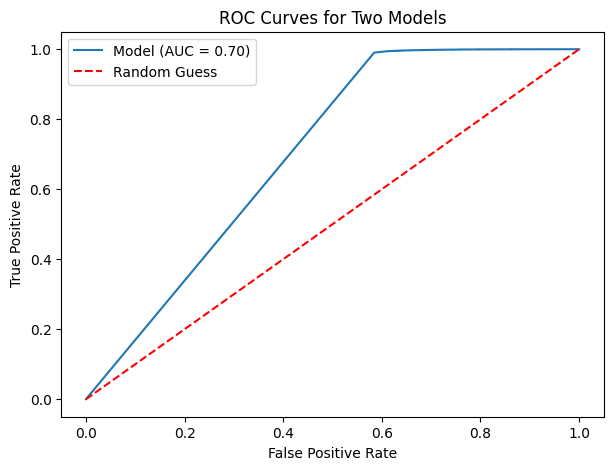

In [34]:
test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [35]:
y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.7938
Recall:    0.6595
F1 Score:  0.6156
OA:        0.6595
AA:        0.6595


In [36]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [37]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/MyMethod {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 4213, 'correct_1': 4885, 'correct_total': 9098, 'total': 10000}, {'dataset': 1, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 304, 'correct_1': 5000, 'correct_total': 5304, 'total': 10000}, {'dataset': 2, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 3090, 'correct_1': 4995, 'correct_total': 8085, 'total': 10000}, {'dataset': 3, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 2975, 'correct_1': 5000, 'correct_total': 7975, 'total': 10000}, {'dataset': 4, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 2573, 'correct_1': 4999, 'correct_total': 7572, 'total': 10000}, {'dataset': 5, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 2923, 'correct_1': 4997, 'correct_total': 7920, 'total': 10000}, {'dataset': 6, 'class0_size': 5000, 'class1_size': 5000, 'correct_0': 0, 'correct_1': 5000, 'correct_total': 5000, 'total': 10000}, {'dataset': 7, 'class0_size': 5000, 'class1

In [38]:
end_time = time.time()
print(f"Train time: {train_time - start_time:.4f} seconds")
print(f"predicting time: {end_time - train_time:.4f} seconds")
print(f"Run time: {end_time - start_time:.4f} seconds")
print(f"mode used: {mode}")

print(timestamp)
print(f"seet used: {seed}")

Train time: 74.8783 seconds
predicting time: 24.0520 seconds
Run time: 98.9303 seconds
mode used: test
20250614_131107
seet used: 10
